In [13]:
from ortools.sat.python import cp_model
import matplotlib.pyplot as plt
from ortools.sat.python import cp_model
import matplotlib.dates as mdates
import datetime
from collections import namedtuple


# Function to convert time to index
def t_to_idx(hour, minute):
    return (hour - 8) * 12 + minute // 5


# Define a namedtuple for start times and durations
MeetingInfo = namedtuple("MeetingInfo", ["start_times", "duration"])

# Possible start times for meetings
meetings = {
    "meeting_a": MeetingInfo(
        start_times=[
            [t_to_idx(hour=8, minute=0), t_to_idx(hour=12, minute=0)],
            [t_to_idx(hour=16, minute=0), t_to_idx(hour=17, minute=0)],
        ],
        duration=24,  # 2 hours
    ),
    "meeting_b": MeetingInfo(
        start_times=[
            [t_to_idx(hour=10, minute=0), t_to_idx(hour=12, minute=0)],
        ],
        duration=6 * 12,  # 6 hours
    ),
    "meeting_c": MeetingInfo(
        start_times=[
            [t_to_idx(hour=16, minute=0), t_to_idx(hour=17, minute=0)],
        ],
        duration=6,  # 30 minutes
    ),
    "meeting_d": MeetingInfo(
        start_times=[
            [t_to_idx(hour=8, minute=0), t_to_idx(hour=10, minute=0)],
            [t_to_idx(hour=12, minute=0), t_to_idx(hour=14, minute=0)],
        ],
        duration=12,  # 1 hour
    ),
    "meeting_e": MeetingInfo(
        start_times=[
            [t_to_idx(hour=10, minute=0), t_to_idx(hour=12, minute=0)],
        ],
        duration=24,  # 2 hours
    ),
    "meeting_f": MeetingInfo(
        start_times=[
            [t_to_idx(hour=14, minute=0), t_to_idx(hour=16, minute=0)],
        ],
        duration=48,  # 4 hours
    ),
    "meeting_g": MeetingInfo(
        start_times=[
            [t_to_idx(hour=14, minute=0), t_to_idx(hour=16, minute=0)],
        ],
        duration=24,  # 2 hours
    ),
    # Additional meetings can be added here...
}

# Create a new CP-SAT model
model = cp_model.CpModel()

# Create start time variables for each meeting
start_time_vars = {
    meeting_name: model.new_int_var_from_domain(
        cp_model.Domain.from_intervals(meeting_info.start_times),
        f"start_{meeting_name}",
    )
    for meeting_name, meeting_info in meetings.items()
}

# rooms
rooms = ["room_a", "room_b"]

room_vars = {
    meeting_name: {
        room: model.new_bool_var(f"{meeting_name}_in_{room}") for room in rooms
    }
    for meeting_name in meetings.keys()
}
for meeting, _room_vars in room_vars.items():
    model.add_exactly_one(_room_vars.values())

# Create interval variables for each meeting
interval_vars = {
    meeting_name: {
        room: model.new_optional_fixed_size_interval_var(
            start=start_time_vars[meeting_name],
            size=meeting_info.duration,
            is_present=room_vars[meeting_name][room],
            name=f"interval_{meeting_name}_in_{room}",
        )
        for room in rooms
    }
    for meeting_name, meeting_info in meetings.items()
}

# Add the no-overlap constraint to the model
for room in rooms:
    model.add_no_overlap([interval_vars[meeting][room] for meeting in meetings])

# Solve the model
solver = cp_model.CpSolver()
status = solver.solve(model)

# Extract and print the solution
if status in (cp_model.OPTIMAL, cp_model.FEASIBLE):
    for meeting in meetings:
        for room in rooms:
            if solver.value(room_vars[meeting][room]):
                start = solver.value(start_time_vars[meeting])
                print(
                    f"{meeting} is in {room} from {start // 12 + 8}:{(start % 12) * 5:02d}"
                )

meeting_a is in room_b from 9:00
meeting_b is in room_a from 10:00
meeting_c is in room_b from 16:00
meeting_d is in room_b from 8:00
meeting_e is in room_b from 11:00
meeting_f is in room_a from 16:00
meeting_g is in room_b from 14:00


meeting_a is in room_b from 8:00 to 10:00
meeting_b is in room_a from 10:00 to 14:00
meeting_c is in room_b from 16:00 to 16:30
meeting_d is in room_b from 12:00 to 13:00
meeting_e is in room_b from 10:00 to 12:00
meeting_f is in room_a from 14:00 to 18:00
meeting_g is in room_b from 14:00 to 16:00


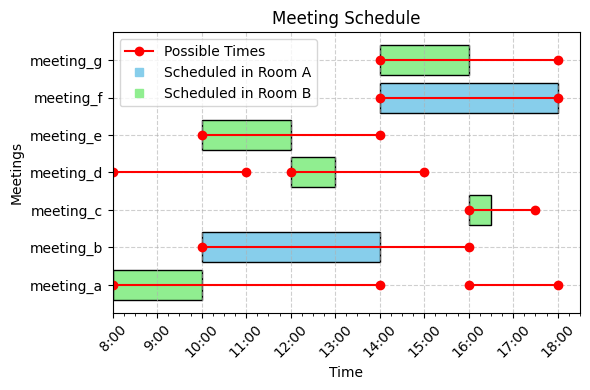

In [24]:
import matplotlib.pyplot as plt
from ortools.sat.python import cp_model
from collections import namedtuple


# Function to convert time to index
def t_to_idx(hour, minute):
    return (hour - 8) * 12 + minute // 5


# Function to convert index back to time
def idx_to_time(index):
    hour = 8 + index // 12
    minute = (index % 12) * 5
    return f"{hour}:{minute:02d}"


# Define meeting information
MeetingInfo = namedtuple("MeetingInfo", ["start_times", "duration"])

# Meeting definitions
meetings = {
    "meeting_a": MeetingInfo(
        start_times=[
            [t_to_idx(8, 0), t_to_idx(12, 0)],
            [t_to_idx(16, 0), t_to_idx(16, 0)],
        ],
        duration=24,
    ),
    "meeting_b": MeetingInfo(
        start_times=[[t_to_idx(10, 0), t_to_idx(12, 0)]], duration=48
    ),
    "meeting_c": MeetingInfo(
        start_times=[[t_to_idx(16, 0), t_to_idx(17, 0)]], duration=6
    ),
    "meeting_d": MeetingInfo(
        start_times=[
            [t_to_idx(8, 0), t_to_idx(10, 0)],
            [t_to_idx(12, 0), t_to_idx(14, 0)],
        ],
        duration=12,
    ),
    "meeting_e": MeetingInfo(
        start_times=[[t_to_idx(10, 0), t_to_idx(12, 0)]], duration=24
    ),
    "meeting_f": MeetingInfo(
        start_times=[[t_to_idx(14, 0), t_to_idx(14, 0)]], duration=48
    ),
    "meeting_g": MeetingInfo(
        start_times=[[t_to_idx(14, 0), t_to_idx(16, 0)]], duration=24
    ),
}

# Create the model
model = cp_model.CpModel()

# Create start time and room variables
start_time_vars = {
    name: model.new_int_var_from_domain(
        cp_model.Domain.from_intervals(info.start_times), f"start_{name}"
    )
    for name, info in meetings.items()
}

rooms = ["room_a", "room_b"]
room_vars = {
    name: {room: model.new_bool_var(f"{name}_in_{room}") for room in rooms}
    for name in meetings
}

# Ensure each meeting is assigned to exactly one room
for name, room_dict in room_vars.items():
    model.add_exactly_one(room_dict.values())

# Create interval variables and add no-overlap constraint
interval_vars = {
    name: {
        room: model.new_optional_fixed_size_interval_var(
            start_time_vars[name],
            info.duration,
            room_vars[name][room],
            f"interval_{name}_in_{room}",
        )
        for room in rooms
    }
    for name, info in meetings.items()
}

for room in rooms:
    model.add_no_overlap([interval_vars[name][room] for name in meetings])

# Solve the model
solver = cp_model.CpSolver()
status = solver.solve(model)

# Extract and print the solution
schedule = {room: [] for room in rooms}
if status in (cp_model.OPTIMAL, cp_model.FEASIBLE):
    for meeting in meetings:
        for room in rooms:
            if solver.value(room_vars[meeting][room]):
                start = solver.value(start_time_vars[meeting])
                duration = meetings[meeting].duration
                schedule[room].append((meeting, start, duration))
                print(
                    f"{meeting} is in {room} from {idx_to_time(start)} to {idx_to_time(start + duration)}"
                )

# Plotting
fig, ax = plt.subplots(figsize=(6, 4))

colors = {"room_a": "skyblue", "room_b": "lightgreen"}

# Plot possible times as shaded areas
for meeting, info in meetings.items():
    for time_range in info.start_times:
        start, end = time_range
        ax.plot(
            [start, end + info.duration],
            [meeting, meeting],
            color="red",
            linestyle="-",
            marker="o",
        )

# Plot scheduled times for each room
for room, meetings in schedule.items():
    for meeting, start, duration in meetings:
        ax.barh(meeting, duration, left=start, color=colors[room], edgecolor="black")

# Customizing the plot
ax.set_xlabel("Time")
ax.set_ylabel("Meetings")
ax.set_title("Meeting Schedule")
ax.grid(True, linestyle="--", alpha=0.6)

# Manually create legend entries
red_line = plt.Line2D((0, 1), (0, 0), color="red", marker="o", linestyle="-")
skyblue_bar = plt.Line2D([], [], color="skyblue", marker="s", linestyle="None")
lightgreen_bar = plt.Line2D([], [], color="lightgreen", marker="s", linestyle="None")

ax.legend(
    [red_line, skyblue_bar, lightgreen_bar],
    ["Possible Times", "Scheduled in Room A", "Scheduled in Room B"],
    loc="upper left",
)


# Convert x-axis to show actual time labels
def time_ticks(x, pos):
    hour, minute = idx_to_time(int(x)).split(":")
    return f"{hour}:{minute}"


ax.xaxis.set_major_formatter(plt.FuncFormatter(time_ticks))
ax.xaxis.set_major_locator(plt.MultipleLocator(12))  # Every hour
ax.xaxis.set_minor_locator(plt.MultipleLocator(3))  # Every 15 minutes

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

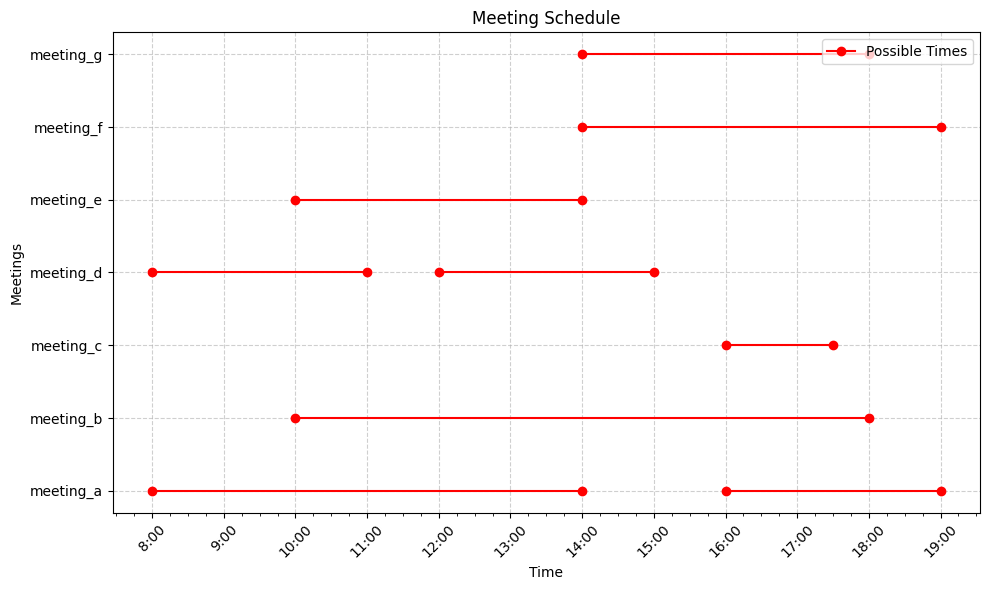

In [15]:
import matplotlib.pyplot as plt
from ortools.sat.python import cp_model
from collections import namedtuple


# Function to convert time to index
def t_to_idx(hour, minute):
    return (hour - 8) * 12 + minute // 5


# Function to convert index back to time
def idx_to_time(index):
    hour = 8 + index // 12
    minute = (index % 12) * 5
    return f"{hour}:{minute:02d}"


# Define a namedtuple for start times and durations
MeetingInfo = namedtuple("MeetingInfo", ["start_times", "duration"])

# Possible start times for meetings
meetings = {
    "meeting_a": MeetingInfo(
        start_times=[
            [t_to_idx(hour=8, minute=0), t_to_idx(hour=12, minute=0)],
            [t_to_idx(hour=16, minute=0), t_to_idx(hour=17, minute=0)],
        ],
        duration=24,  # 2 hours
    ),
    "meeting_b": MeetingInfo(
        start_times=[
            [t_to_idx(hour=10, minute=0), t_to_idx(hour=12, minute=0)],
        ],
        duration=6 * 12,  # 6 hours
    ),
    "meeting_c": MeetingInfo(
        start_times=[
            [t_to_idx(hour=16, minute=0), t_to_idx(hour=17, minute=0)],
        ],
        duration=6,  # 30 minutes
    ),
    "meeting_d": MeetingInfo(
        start_times=[
            [t_to_idx(hour=8, minute=0), t_to_idx(hour=10, minute=0)],
            [t_to_idx(hour=12, minute=0), t_to_idx(hour=14, minute=0)],
        ],
        duration=12,  # 1 hour
    ),
    "meeting_e": MeetingInfo(
        start_times=[
            [t_to_idx(hour=10, minute=0), t_to_idx(hour=12, minute=0)],
        ],
        duration=24,  # 2 hours
    ),
    "meeting_f": MeetingInfo(
        start_times=[
            [t_to_idx(hour=14, minute=0), t_to_idx(hour=15, minute=0)],
        ],
        duration=48,  # 4 hours
    ),
    "meeting_g": MeetingInfo(
        start_times=[
            [t_to_idx(hour=14, minute=0), t_to_idx(hour=16, minute=0)],
        ],
        duration=24,  # 2 hours
    ),
    # Additional meetings can be added here...
}

# Create a new CP-SAT model
model = cp_model.CpModel()

# Create start time variables for each meeting
start_time_vars = {
    meeting_name: model.NewIntVarFromDomain(
        cp_model.Domain.FromIntervals(
            [
                [start, end + meetings[meeting_name].duration]
                for start, end in meeting_info.start_times
            ]
        ),
        f"start_{meeting_name}",
    )
    for meeting_name, meeting_info in meetings.items()
}

# Rooms
rooms = ["room_a", "room_b"]

room_vars = {
    meeting_name: {
        room: model.NewBoolVar(f"{meeting_name}_in_{room}") for room in rooms
    }
    for meeting_name in meetings.keys()
}

for meeting, _room_vars in room_vars.items():
    model.AddExactlyOne(_room_vars.values())

# Create interval variables for each meeting
interval_vars = {
    meeting_name: {
        room: model.NewOptionalFixedSizeIntervalVar(
            start=start_time_vars[meeting_name],
            size=meeting_info.duration,
            is_present=room_vars[meeting_name][room],
            name=f"interval_{meeting_name}_in_{room}",
        )
        for room in rooms
    }
    for meeting_name, meeting_info in meetings.items()
}

# Add the no-overlap constraint to the model
for room in rooms:
    model.AddNoOverlap([interval_vars[meeting][room] for meeting in meetings])

# Solve the model
solver = cp_model.CpSolver()
status = solver.Solve(model)

# Extract and print the solution
schedule = {room: [] for room in rooms}
if status in (cp_model.OPTIMAL, cp_model.FEASIBLE):
    for meeting in meetings:
        for room in rooms:
            if solver.Value(room_vars[meeting][room]):
                start = solver.Value(start_time_vars[meeting])
                duration = meetings[meeting].duration
                schedule[room].append((meeting, start, duration))
                print(
                    f"{meeting} is in {room} from {idx_to_time(start)} to {idx_to_time(start + duration)}"
                )

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

colors = {"room_a": "skyblue", "room_b": "lightgreen"}

# Plot possible times as shaded areas
for meeting, info in meetings.items():
    for time_range in info.start_times:
        start, end = time_range
        ax.plot(
            [start, end + info.duration],
            [meeting, meeting],
            color="red",
            linestyle="-",
            marker="o",
            label="Possible Times"
            if meeting == "meeting_a" and time_range == info.start_times[0]
            else "",
        )

# Plot scheduled times for each room
for room, meetings in schedule.items():
    for meeting, start, duration in meetings:
        ax.barh(
            meeting,
            duration,
            left=start,
            color=colors[room],
            edgecolor="black",
            label=f"Scheduled in {room}" if meeting == "meeting_a" else "",
        )

# Customizing the plot
ax.set_xlabel("Time")
ax.set_ylabel("Meetings")
ax.set_title("Meeting Schedule")
ax.grid(True, linestyle="--", alpha=0.6)

# To avoid duplicate legends
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc="upper right")


# Convert x-axis to show actual time labels
def time_ticks(x, pos):
    hour, minute = idx_to_time(int(x)).split(":")
    return f"{hour}:{minute}"


ax.xaxis.set_major_formatter(plt.FuncFormatter(time_ticks))
ax.xaxis.set_major_locator(plt.MultipleLocator(12))  # Every hour
ax.xaxis.set_minor_locator(plt.MultipleLocator(3))  # Every 15 minutes

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()